In [1]:
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [2]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.applications import ResNet50
#from keras_squeezenet.squeezenet import SqueezeNet
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
import os
import PIL
import PIL.Image
import pathlib
from sklearn.model_selection import train_test_split
data_dir = pathlib.Path("/Users/Yernar-PC/DEEP LEARNING/PART2")
data_dir_train = pathlib.Path("/Users/Yernar-PC/DEEP LEARNING/Insulator/total data/all/*/*")
#data_dir_test = pathlib.Path("C:/Users/Davran/0_Deep_Learning_Project/Implant Inspection/test/*/*")

In [4]:
filenames = tf.io.gfile.glob(str(data_dir_train))
#filenames.extend(tf.io.gfile.glob(str(data_dir_test)))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [5]:
COUNT_CLEAN = len([filename for filename in filenames if "Clean" in filename])
print("Clean images count in training set: " + str(COUNT_CLEAN))

COUNT_POLLUTED = len([filename for filename in filenames if "Polluted" in filename])
print("Polluted images count in training set: " + str(COUNT_POLLUTED))

Clean images count in training set: 71
Polluted images count in training set: 205


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'\\Users\\Yernar-PC\\DEEP LEARNING\\Insulator\\total data\\all\\Polluted\\DSCF0025.JPG'
b'\\Users\\Yernar-PC\\DEEP LEARNING\\Insulator\\total data\\all\\Polluted\\DSCF0064.JPG'
b'\\Users\\Yernar-PC\\DEEP LEARNING\\Insulator\\total data\\all\\Polluted\\20200617_125813.jpg'
b'\\Users\\Yernar-PC\\DEEP LEARNING\\Insulator\\total data\\all\\Polluted\\20180320_123204.jpg'
b'\\Users\\Yernar-PC\\DEEP LEARNING\\Insulator\\total data\\all\\Polluted\\20200617_124537.jpg'


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Train images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validation images count: " + str(VAL_IMG_COUNT))

Train images count: 220
Validation images count: 56


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(data_dir) + "/All/*")])
CLASS_NAMES

array([], dtype=float64)

In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    if parts[-2] == 'Clean':
        return 0
    else:
        return 1

In [10]:
def decode_img(img):
    # convert the compressed string
    img_X = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img_X = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(img_X)
    #img_X = tf.image.convert_image_dtype(img_X, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img_X, IMAGE_SIZE)

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = (100, 100)
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
X_train = []
y_train = []

for image, label in train_ds:
    X_train.append(image)
    y_train.append(label)    
X_train = np.array(X_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'float32')

shuffled_idx = np.random.permutation(TRAIN_IMG_COUNT)
X_train[:] = X_train[shuffled_idx]
y_train[:] = y_train[shuffled_idx]
print(X_train.shape)
print(y_train.shape)

(220, 100, 100, 3)
(220,)


In [14]:
X_val = []
y_val = []

for image, label in val_ds:
    X_val.append(image)
    y_val.append(label)    
X_val = np.array(X_val, dtype = 'float32')
y_val = np.array(y_val, dtype = 'float32')

shuffled_idx = np.random.permutation(VAL_IMG_COUNT)
X_val[:] = X_val[shuffled_idx]
y_val[:] = y_val[shuffled_idx]
print(X_val.shape)
print(y_val.shape)

(56, 100, 100, 3)
(56,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


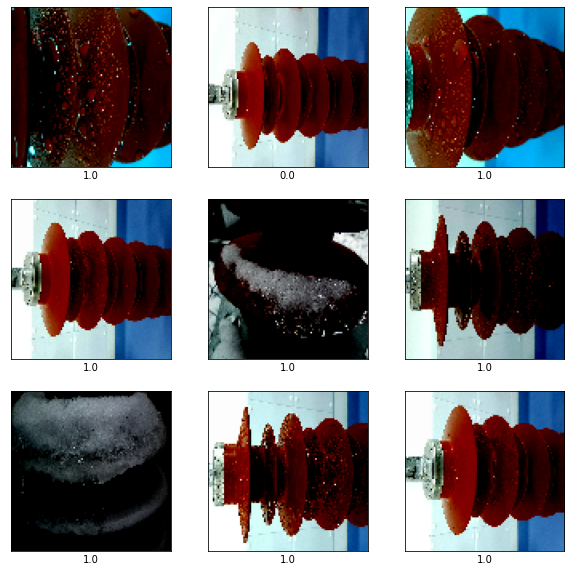

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap = plt.cm.binary)
    plt.xlabel(y_train[i])
    
# The figure below shows the downsampled images of insulators with the labels below.

In [16]:
#X_train = np.expand_dims(X_train, axis=0)

In [17]:
#X_train.shape

In [18]:
IMG_SHAPE = IMAGE_SIZE + (3, )
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [19]:
#image_batch, label_batch = next(iter(X_train))
feature_batch = base_model(X_train)
print(feature_batch.shape)

(220, 4, 4, 2560)


In [20]:
base_model.trainable = False

In [21]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 100, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 100, 100, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 101, 101, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

__________________________________________________________________________________________________
block5j_expand_activation (Acti (None, 7, 7, 1344)   0           block5j_expand_bn[0][0]          
__________________________________________________________________________________________________
block5j_dwconv (DepthwiseConv2D (None, 7, 7, 1344)   33600       block5j_expand_activation[0][0]  
__________________________________________________________________________________________________
block5j_bn (BatchNormalization) (None, 7, 7, 1344)   5376        block5j_dwconv[0][0]             
__________________________________________________________________________________________________
block5j_activation (Activation) (None, 7, 7, 1344)   0           block5j_bn[0][0]                 
__________________________________________________________________________________________________
block5j_se_squeeze (GlobalAvera (None, 1344)         0           block5j_activation[0][0]         
__________

Total params: 64,097,687
Trainable params: 0
Non-trainable params: 64,097,687
__________________________________________________________________________________________________


In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(220, 2560)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(220, 1)


In [24]:
inputs = tf.keras.Input(shape=(100, 100, 3))
#x = data_augmentation(inputs)
#x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 4, 4, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
_________________________________________________________________


In [27]:
len(model.trainable_variables)

2

In [28]:
type(X_val)

numpy.ndarray

In [29]:
tf.config.run_functions_eagerly(True)


In [30]:
history = model.fit(X_train,
                    y_train,
                    epochs=150,
                    validation_data = (X_val, y_val)
                    )

Epoch 1/150


C:\Users\Yernar-PC\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


7/7 [==============================] - 11s 1s/step - loss: 0.7876 - accuracy: 0.3000 - val_loss: 0.6553 - val_accuracy: 0.2500
Epoch 2/150
7/7 [==============================] - 10s 1s/step - loss: 0.6387 - accuracy: 0.4455 - val_loss: 0.5671 - val_accuracy: 0.7500
Epoch 3/150
7/7 [==============================] - 11s 2s/step - loss: 0.5907 - accuracy: 0.6818 - val_loss: 0.5655 - val_accuracy: 0.7500
Epoch 4/150
7/7 [==============================] - 10s 1s/step - loss: 0.5877 - accuracy: 0.7364 - val_loss: 0.5714 - val_accuracy: 0.7500
Epoch 5/150
7/7 [==============================] - 11s 2s/step - loss: 0.5799 - accuracy: 0.7409 - val_loss: 0.5673 - val_accuracy: 0.7500
Epoch 6/150
7/7 [==============================] - 10s 2s/step - loss: 0.5886 - accuracy: 0.7364 - val_loss: 0.5631 - val_accuracy: 0.7500
Epoch 7/150
7/7 [==============================] - 10s 1s/step - loss: 0.5834 - accuracy: 0.6955 - val_loss: 0.5618 - val_accuracy: 0.7500
Epoch 8/150
7/7 [======================

Epoch 60/150
7/7 [==============================] - 10s 1s/step - loss: 0.5862 - accuracy: 0.6909 - val_loss: 0.5610 - val_accuracy: 0.7500
Epoch 61/150
7/7 [==============================] - 10s 1s/step - loss: 0.5815 - accuracy: 0.7045 - val_loss: 0.5611 - val_accuracy: 0.7500
Epoch 62/150
7/7 [==============================] - 10s 1s/step - loss: 0.6171 - accuracy: 0.7045 - val_loss: 0.5613 - val_accuracy: 0.7500
Epoch 63/150
7/7 [==============================] - 10s 1s/step - loss: 0.5838 - accuracy: 0.6955 - val_loss: 0.5610 - val_accuracy: 0.7500
Epoch 64/150
7/7 [==============================] - 10s 1s/step - loss: 0.5896 - accuracy: 0.6864 - val_loss: 0.5616 - val_accuracy: 0.7500
Epoch 65/150
7/7 [==============================] - 10s 1s/step - loss: 0.6123 - accuracy: 0.6455 - val_loss: 0.5615 - val_accuracy: 0.7500
Epoch 66/150
7/7 [==============================] - 10s 1s/step - loss: 0.5897 - accuracy: 0.6909 - val_loss: 0.5613 - val_accuracy: 0.7500
Epoch 67/150
7/7 [==

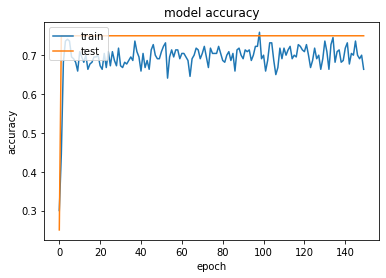

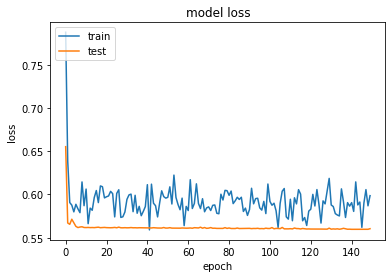

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()